In [1]:
suppressMessages(library(caret))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggvenn))
suppressMessages(library(reshape2))
suppressMessages(library(pROC))
suppressMessages(library(magrittr))
suppressMessages(library(tidyr))
suppressMessages(library(stringr))

In [2]:
gene.list = read.delim("../files_for_manuscript/gencode.biotype.name.key.tsv")
metadata = read.delim("../files_for_manuscript/metadata_discovery.txt")
top = read.delim("../files_for_manuscript/top150genes.csv")
counts_val = read.delim("../files_for_manuscript/count_matrix_validation.txt", row.names=c(1))
metadata_val = read.delim("../files_for_manuscript/metadata_validation.txt", header=T)

## GREEDY FORWARD SEARCH

In [3]:
set.seed(42)
counts = read.delim("../files_for_manuscript/count_matrix.txt", row.names=c(1))
top = read.delim("../files_for_manuscript/top150genes.csv")

gene.list_keep = gene.list[gene.list$gene_name %in% top$x,1]
counts = counts[rownames(counts) %in% gene.list_keep,]

counts= counts %>% edgeR::cpm() %>% t() %>% data.frame()  

counts$Cornell_ID = rownames(counts)

In [4]:
head(counts)

,ENSG00000002549.13,ENSG00000005381.8,ENSG00000019169.11,ENSG00000025039.15,ENSG00000030419.17,ENSG00000043093.15,ENSG00000060558.4,ENSG00000065054.14,ENSG00000066926.13,ENSG00000069493.15,⋯,ENSG00000221869.5,ENSG00000221963.6,ENSG00000222009.8,ENSG00000232533.1,ENSG00000255221.4,ENSG00000258227.7,ENSG00000267751.5,ENSG00000273033.2,ENSG00000287839.1,Cornell_ID
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
R2D2_U100_combined,2602.547,575.78479,414.56505,898.2243,829.1301,5043.875,2786.798,35191.97,8982.243,1842.5113,⋯,3477.740,5159.032,138.1884,829.1301,0.00000,230.31392,23.03139,46.06278,0.00000,R2D2_U100_combined
R2D2_U102_combined,3456.059,352.65905,70.53181,846.3817,564.2545,3032.868,1622.232,52475.67,2398.082,211.5954,⋯,1692.763,3738.186,211.5954,282.1272,0.00000,141.06362,0.00000,0.00000,0.00000,R2D2_U102_combined
R2D2_U103_combined,6918.383,97.90164,0.00000,522.1421,456.8743,8060.568,5090.885,35440.39,19156.088,424.2404,⋯,1011.650,5808.831,326.3388,1272.7213,0.00000,32.63388,0.00000,0.00000,163.16940,R2D2_U103_combined
R2D2_U105_combined,2155.089,269.38618,115.45122,558.0142,134.6931,10448.336,2847.797,33480.85,32018.472,423.3211,⋯,1789.494,2462.959,153.9350,577.2561,0.00000,134.69309,38.48374,57.72561,19.24187,R2D2_U105_combined
R2D2_U106_combined,1338.864,183.76562,210.01785,656.3058,866.3236,9214.533,3071.511,14464.98,21946.865,4830.4106,⋯,1942.665,4174.105,472.5402,183.7656,0.00000,183.76562,26.25223,236.27008,472.54017,R2D2_U106_combined
R2D2_U110_combined,4124.285,417.06249,486.57290,1228.0173,1042.6562,6001.066,3637.712,16056.91,10472.903,4471.8367,⋯,3243.819,5560.833,231.7014,834.1250,23.17014,69.51041,23.17014,115.85069,92.68055,R2D2_U110_combined


In [5]:
train_ind = sample(seq_len(nrow(counts)), size=0.70*nrow(counts))
metadata$sample = paste0(metadata$Cornell_ID, "_combined")

counts_train = counts[train_ind,]
counts_test = counts[-train_ind,]


metadata_train = metadata[metadata$sample %in% rownames(counts_train),]
metadata_test = metadata[metadata$sample %in% rownames(counts_test),]


In [6]:
metadata_train%>%group_by(Microbiologic.reference.standard) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n))

metadata_test%>%group_by(Microbiologic.reference.standard) %>%
  summarise(n = n()) %>%
  mutate(freq = n / sum(n))

Microbiologic.reference.standard,n,freq
<chr>,<int>,<dbl>
TB Negative,53,0.4173228
TB Positive,74,0.5826772


Microbiologic.reference.standard,n,freq
<chr>,<int>,<dbl>
TB Negative,29,0.5272727
TB Positive,26,0.4727273


In [7]:
counts_train.melt = melt(counts_train,id.var="Cornell_ID")
counts_train.melt$Cornell_ID = gsub(counts_train.melt$Cornell_ID, pattern="_combined", replacement="")
counts_train.melt = merge(counts_train.melt, metadata, by="Cornell_ID")
counts_train.melt = merge(counts_train.melt,  gene.list[gene.list$gene_name %in%top$x,1:2], by.x="variable", by.y="gene_id")


In [8]:
counts_test.melt = melt(counts_test,id.var="Cornell_ID")
counts_test.melt$Cornell_ID = gsub(counts_test.melt$Cornell_ID, pattern="_combined", replacement="")
counts_test.melt = merge(counts_test.melt, metadata, by="Cornell_ID")
counts_test.melt = merge(counts_test.melt,  gene.list[gene.list$gene_name %in% top$x,1:2], by.x="variable", by.y="gene_id")

counts2 = counts_train %>% t() %>% data.frame()

In [9]:
starts = gene.list[gene.list$gene_name %in% top$x,1]
starts_df = matrix(ncol=4, NA)
colnames(starts_df)=c("gene","auc", "lowci","upci")

for (s in starts){
    df = merge(counts2[rownames(counts2)==s,] %>% t() 
               %>% data.frame()  
               %>% mutate_all(as.numeric) %>%
               mutate( log2( . + 1)) %>% 
               set_colnames("score"), metadata_train, 
               by.x="row.names", by.y="sample")
    auc = auc(df$Microbiologic.reference.standard, as.numeric(df$score))
    lowci = ci.auc(df$Microbiologic.reference.standard, as.numeric(df$score))[1]
    upci = ci.auc(df$Microbiologic.reference.standard, as.numeric(df$score))[3]
    starts_df = rbind(starts_df, cbind("gene"=s, "auc"=auc, "lowci" = lowci, "upci" = upci))
}

starts_df = starts_df %>% data.frame() %>% dplyr::arrange(desc(auc)) 



plot_df = matrix(ncol=4, NA)
colnames(plot_df)=c("combination","auc", "lowci","upci")

plot_df = rbind(plot_df, cbind("combination"=starts_df[1,1], "auc"=starts_df[1,2], "lowci" = starts_df[1,3], "upci"=starts_df[1,4]))

best_auc = plot_df %>% data.frame() %>% filter(row_number()==n())
best_auc = best_auc$auc
best_auc

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, c

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Set

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, c

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Set

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, c

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Set

[1] "0.885007649158593"

In [10]:
res = counts_train.melt %>% group_by(variable,Microbiologic.reference.standard) %>% summarise(val = mean(value))
res2 = dcast(res, variable ~ Microbiologic.reference.standard)
res2$diff = ifelse((res2$`TB Positive` - res2$`TB Negative` > 0), "up", "down")

`summarise()` has grouped output by 'variable'. You can override using the
`.groups` argument.
Using val as value column: use value.var to override.



In [11]:
df2 = matrix(ncol=4,NA)
colnames(df2)=c("combination","auc", "lowci","upci")

start = plot_df[2,1]
rest = starts[!(starts %in% start)]

for (r in 1:length(rest)){
    
    comb = c(start,rest[r])
    
    pos = res2[res2$diff == "up",] %>% filter(variable %in% comb) %>% pull(variable)
    neg =res2[res2$diff == "down",] %>% filter(variable %in% comb)%>% pull(variable)


    if (length(pos)==1){
        pos_counts =counts2[rownames(counts2) %in% pos,]   %>% data.frame() %>% mutate_all(as.numeric) %>% 
        mutate( log2( . + 1))%>% 
        t()%>% set_colnames("pos_score")
    } else if (length(pos)>1) {
        pos_counts =counts2[rownames(counts2) %in% pos,]   %>% 
        data.frame() %>% mutate_all(as.numeric) %>% 
       mutate( log2( . + 1)) %>% 
        summarise_all(mean) %>% t() %>% set_colnames("pos_score")      
    } else{
        pos_counts=NA
    }
    
    if (length(neg)==1){
        neg_counts =counts2[rownames(counts2) %in% neg,]   %>% data.frame() %>% mutate_all(as.numeric) %>% 
        mutate( log2( . + 1))%>%
        t() %>%
        set_colnames("neg_score")
    } else if (length(neg)>1) {
        neg_counts =counts2[rownames(counts2) %in% neg,]   %>% 
        data.frame() %>% mutate_all(as.numeric) %>% 
       mutate( log2( . + 1))%>%
        summarise_all(mean) %>% t() %>% set_colnames("neg_score") 
    } else {
        neg_counts = NA
    }
    
    
    if (!is.na(neg_counts) & !is.na(pos_counts)){
        df_test = merge(pos_counts,neg_counts, by="row.names")
        df_test = merge(df_test, metadata_train, by.x="Row.names", by.y="sample")

        df_test$score = df_test$pos_score - df_test$neg_score
        auc = auc(df_test$Microbiologic.reference.standard, as.numeric(df_test$score))
        lowci = ci.auc(df_test$Microbiologic.reference.standard, as.numeric(df_test$score))[1]
        upci = ci.auc(df_test$Microbiologic.reference.standard, as.numeric(df_test$score))[3]
        
        df2 = rbind(df2, cbind("combination" = paste(comb, collapse="_"),"auc"=auc, "lowci" = lowci, "upci"=upci))
    } else if (is.na(neg_counts) & !is.na(pos_counts)){
        df_test = merge(pos_counts, metadata_train, by.x="row.names", by.y="sample")

        df_test$score = df_test$pos_score
        auc = auc(df_test$Microbiologic.reference.standard, as.numeric(df_test$score))
    lowci = ci.auc(df_test$Microbiologic.reference.standard, as.numeric(df_test$score))[1]
        upci = ci.auc(df_test$Microbiologic.reference.standard, as.numeric(df_test$score))[3]
        
        df2 = rbind(df2, cbind("combination" = paste(comb, collapse="_"),"auc"=auc, "lowci"=lowci, "upci"=upci))
    } else {
        df_test = merge(neg_counts, metadata_train, by.x="row.names", by.y="sample")

        df_test$score = df_test$neg_score
        auc = auc(df_test$Microbiologic.reference.standard, as.numeric(df_test$score))
       lowci = ci.auc(df_test$Microbiologic.reference.standard, as.numeric(df_test$score))[1]
        upci = ci.auc(df_test$Microbiologic.reference.standard, as.numeric(df_test$score))[3]
        
        df2 = rbind(df2, cbind("combination" = paste(comb, collapse="_"),"auc"=auc, "lowci"=lowci, "upci"=upci))
    }
}

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Pos

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning mes

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting dir

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Pos

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB 

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(p

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels:

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(p

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(p

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning mess

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB 

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB 

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting le

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting dir

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning mess

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning mes

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning mes

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning mess

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning mess

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the

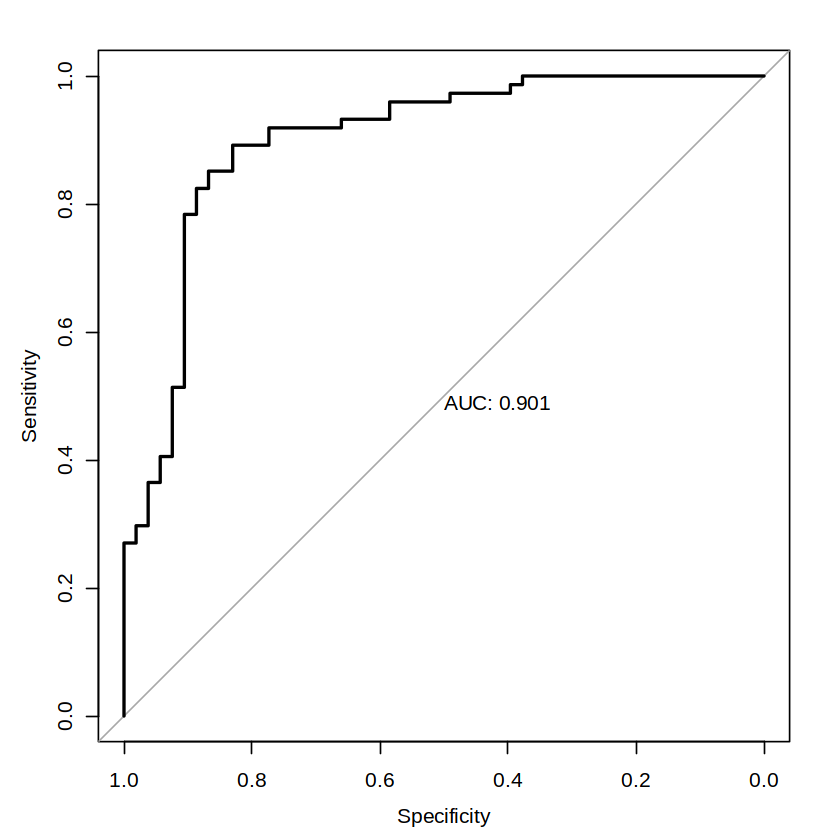

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting lev

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting lev

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB 

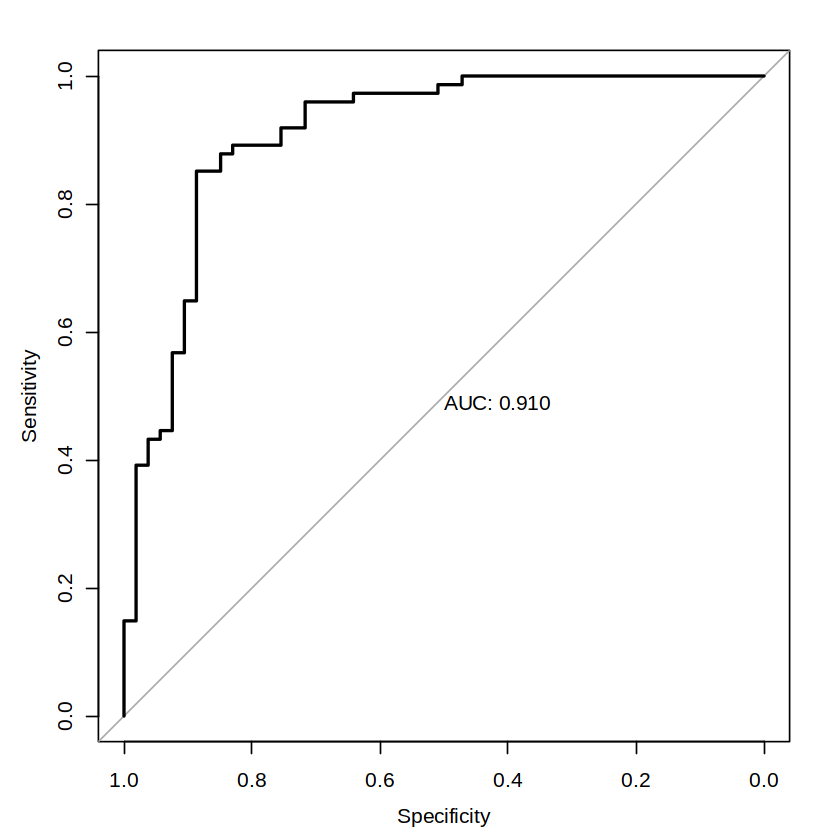

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting lev

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting lev

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB 

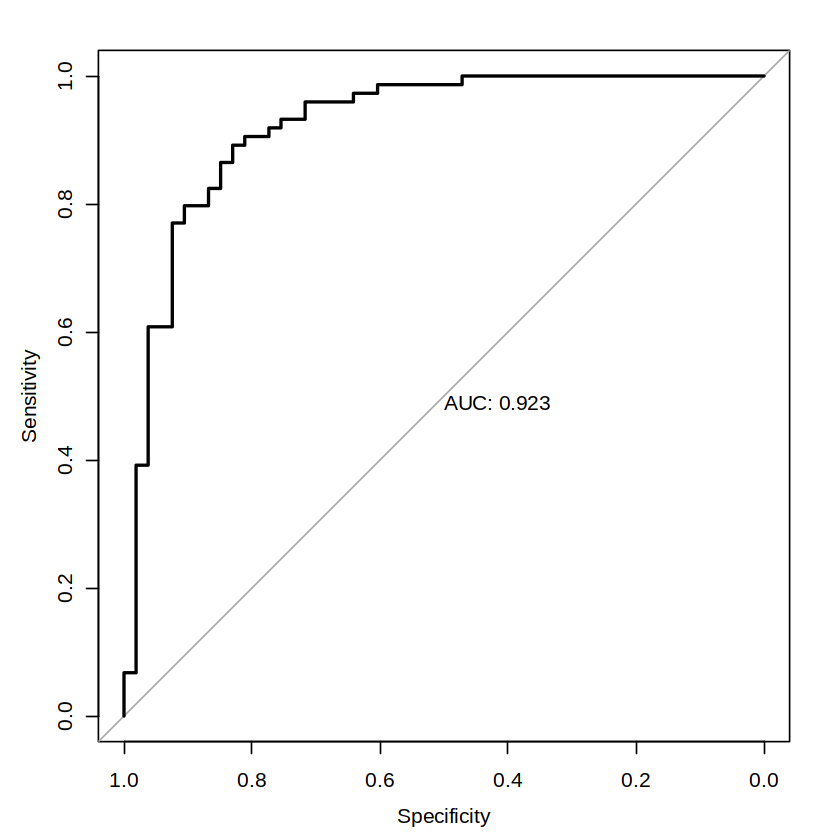

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting lev

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting lev

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting dir

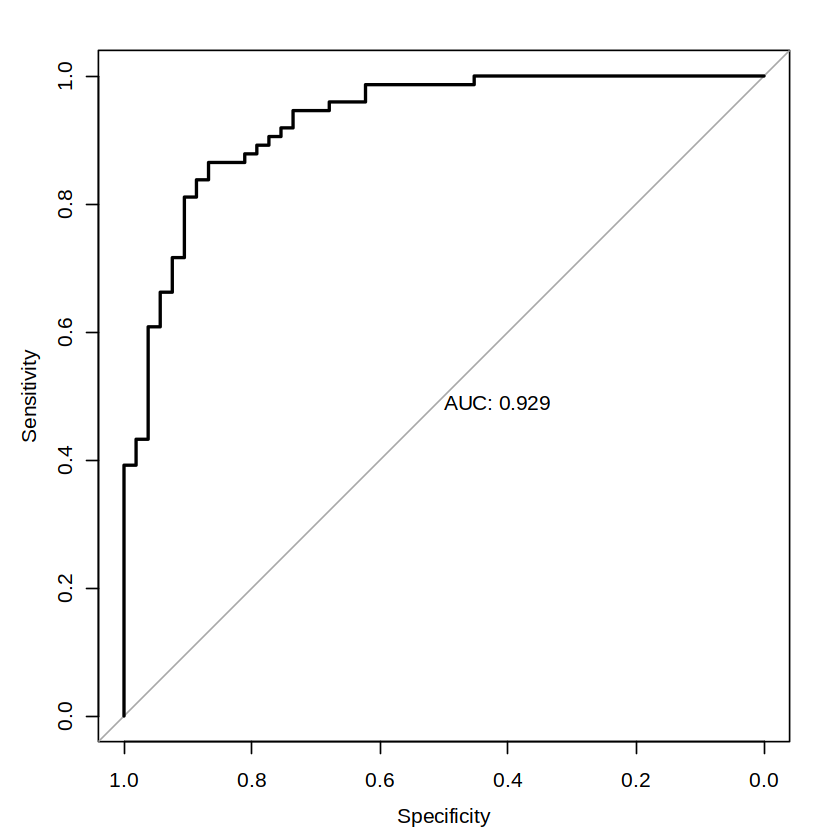

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting lev

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting lev

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(p

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels:

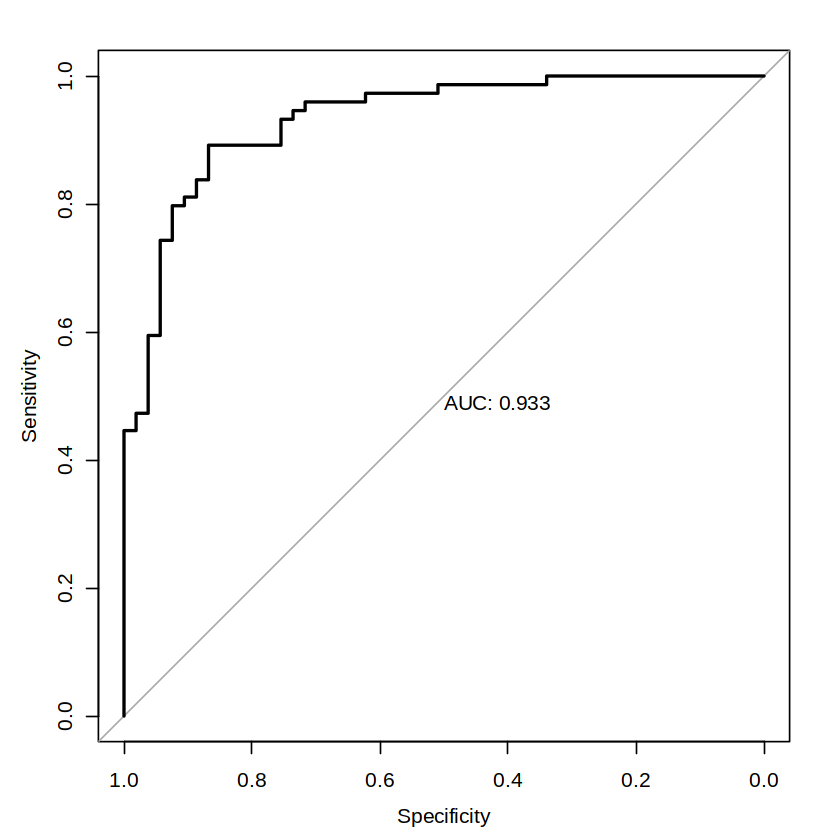

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels:

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting lev

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning mess

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting dir

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Pos

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning mes

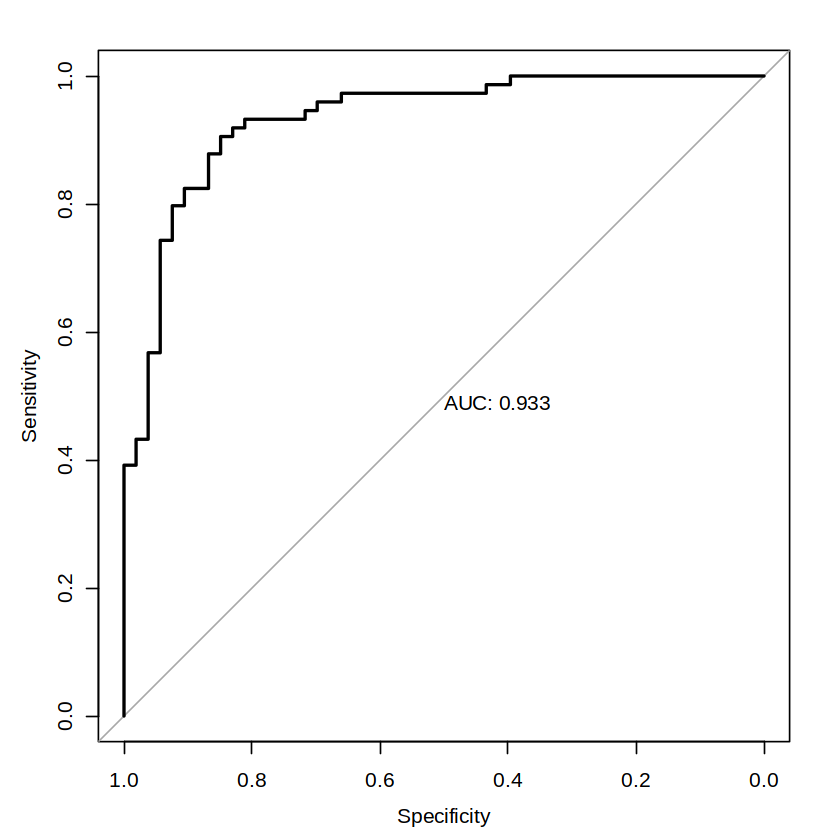

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning mess

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning mes

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning mess

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning mes

Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Warning mess

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls > cases

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning mes

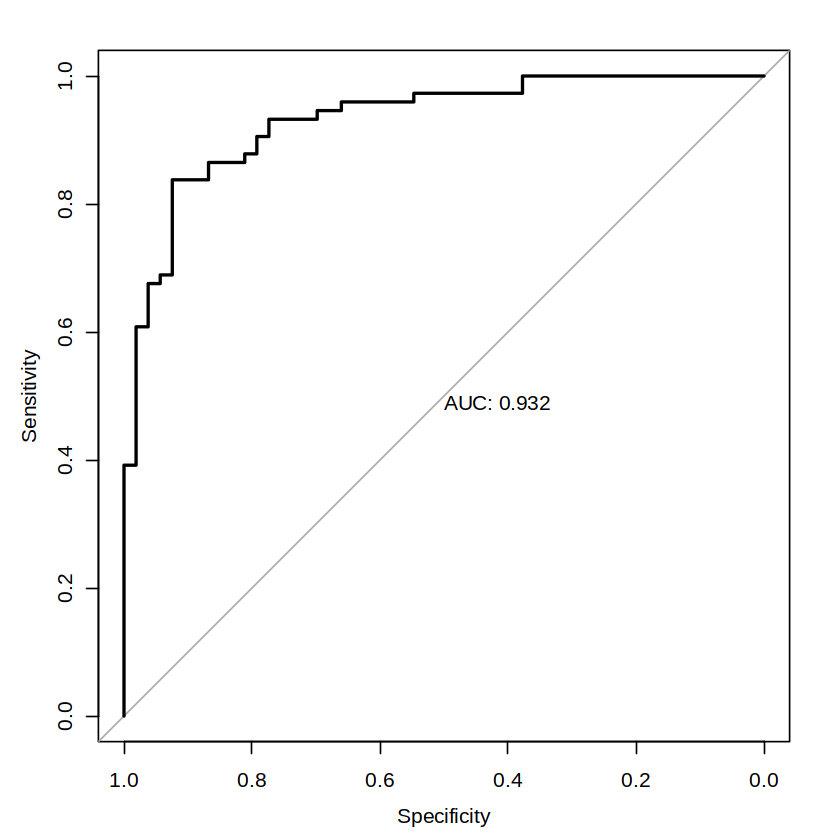

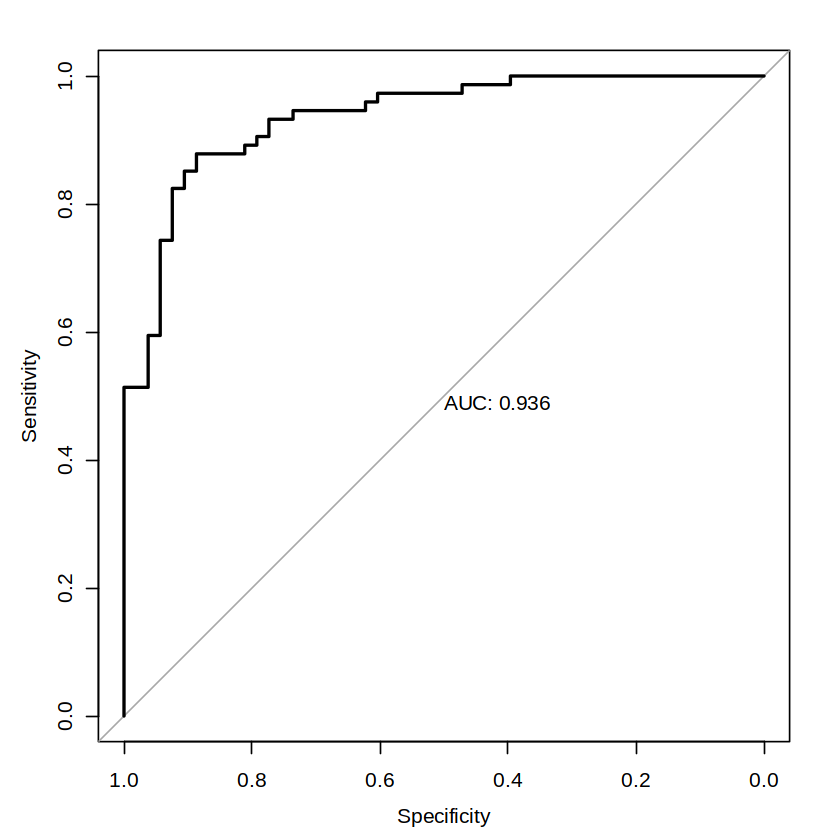

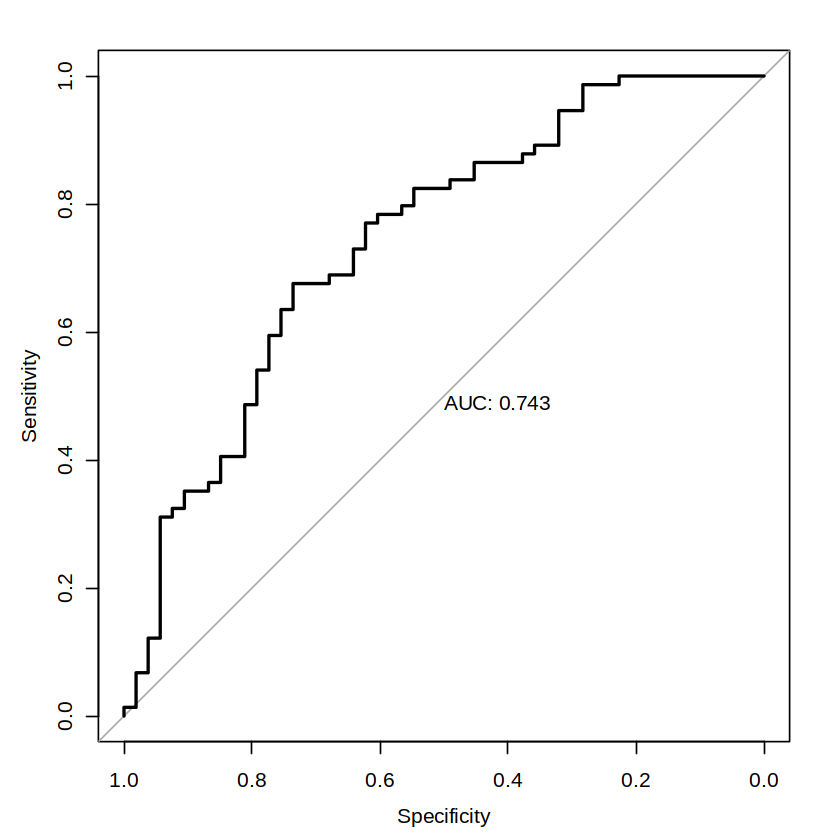

In [12]:
while (!is.na(best_auc)){
    sorted_df = df2 %>% data.frame()%>% filter(as.numeric(auc) > best_auc) %>% arrange(desc(auc))
    new_start = unlist(str_split(sorted_df[1,1], "_"))
    new_rest = starts[!(starts %in% new_start)]

    df2 = matrix(ncol=4,NA)
    colnames(df2)=c("combination","auc", "lowci", "upci")
    best_auc = as.numeric(sorted_df[1,2])
    plot_df = rbind(plot_df, cbind("combination"=sorted_df[1,1], "auc"=best_auc, "lowci" = sorted_df[1,3], "upci" = sorted_df[1,4]))
    
    for (r in 1:length(new_rest)){
    comb = c(new_start,new_rest[r])
    
    pos = res2[res2$diff == "up",] %>% filter(variable %in% comb) %>% pull(variable)
    neg =res2[res2$diff == "down",] %>% filter(variable %in% comb)%>% pull(variable)


    if (length(pos)==1){
        pos_counts =counts2[rownames(counts2) %in% pos,]   %>% data.frame() %>% mutate_all(as.numeric) %>% 
        mutate( log2( . + 1))%>% 
        t()%>% set_colnames("pos_score")
    } else if (length(pos)>1) {
        pos_counts =counts2[rownames(counts2) %in% pos,]   %>% 
        data.frame() %>% mutate_all(as.numeric) %>% 
        mutate( log2( . + 1)) %>% 
        summarise_all(mean) %>% t() %>% set_colnames("pos_score")      
    } else{
        pos_counts=NA
    }
    
    if (length(neg)==1){
        neg_counts =counts2[rownames(counts2) %in% neg,]   %>% data.frame() %>% mutate_all(as.numeric) %>% 
        mutate( log2( . + 1)) %>% 
        t() %>%
        set_colnames("neg_score")
    } else if (length(neg)>1) {
        neg_counts =counts2[rownames(counts2) %in% neg,]   %>% 
        data.frame() %>% mutate_all(as.numeric) %>% 
        mutate( log2( . + 1))%>% 
        summarise_all(mean) %>% t() %>% set_colnames("neg_score") 
    } else {
        neg_counts = NA
    }
    
    
    
    if (!is.na(neg_counts) & !is.na(pos_counts)){
        df_test = merge(pos_counts,neg_counts, by="row.names")
        df_test = merge(df_test, metadata_train, by.x="Row.names", by.y="sample")

        df_test$score = df_test$pos_score - df_test$neg_score
        auc = auc(df_test$Microbiologic.reference.standard, df_test$score)
        lowci = ci.auc(df_test$Microbiologic.reference.standard, df_test$score)[1]
        upci = ci.auc(df_test$Microbiologic.reference.standard, df_test$score)[3]
        df2 = rbind(df2, cbind("combination" = paste(comb, collapse="_"),"auc"=auc, "lowci"=lowci, "upci"=upci))
    } else if (is.na(neg_counts) & !is.na(pos_counts)){
        df_test = merge(pos_counts, metadata_train, by.x="row.names", by.y="sample")

        df_test$score = df_test$pos_score
        auc = auc(df_test$Microbiologic.reference.standard, df_test$score)
        
        
        lowci = ci.auc(df_test$Microbiologic.reference.standard, df_test$score)[1]
        upci = ci.auc(df_test$Microbiologic.reference.standard, df_test$score)[3]
        df2 = rbind(df2, cbind("combination" = paste(comb, collapse="_"),"auc"=auc, "lowci"=lowci, "upci"=upci))
    } else {
        df_test = merge(neg_counts, metadata_train, by.x="row.names", by.y="sample")

        df_test$score = df_test$neg_score
        auc = auc(df_test$Microbiologic.reference.standard, df_test$score)
        
        
        lowci = ci.auc(df_test$Microbiologic.reference.standard, df_test$score)[1]
        upci = ci.auc(df_test$Microbiologic.reference.standard, df_test$score)[3]
        df2 = rbind(df2, cbind("combination" = paste(comb, collapse="_"),"auc"=auc, "lowci"=lowci, "upci"=upci))
    }
}
    
    plot.roc(df_test$Microbiologic.reference.standard, df_test$score, print.auc=TRUE)
}



## FIG 2A

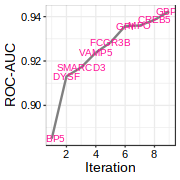

In [13]:
plot_df2 = data.frame(plot_df)
plot_df2 = plot_df2[!is.na(plot_df2$auc),]
plot_df2$iteration = c(seq(1:dim(plot_df2)[1]))
plot_df2$last = sapply(strsplit(plot_df2$combination ,"_"), tail, 1)
plot_df2 = merge(plot_df2, gene.list, by.x="last", by.y="gene_id")

options(repr.plot.height=1.5, repr.plot.width=1.5)

ggplot(plot_df2, aes(x=iteration, y=as.numeric(auc), label=gene_name))+ geom_line(color="grey50")+
theme_bw(base_size=6) + xlab("# Genes in Model") + ylab("AUC") + 
geom_text(hjust=0.5, vjust=0.5, size=2, color="deeppink")+
scale_x_continuous(breaks=scales::pretty_breaks()) +
ylab("ROC-AUC") + xlab("Iteration") +
theme(axis.text=element_text(size=6, color="black"),
     axis.title=element_text(size=8, color="black"))


In [14]:
best = plot_df2 %>% arrange(iteration) %>% filter(row_number() ==n())
best = best[1,2]
best_genes = unlist(str_split(best,"_"))
counts_test = counts_test %>% t() %>% data.frame()


    pos = res2[res2$diff == "up",] %>% filter(variable %in% best_genes) %>% pull(variable)
    neg =res2[res2$diff == "down",] %>% filter(variable %in% best_genes)%>% pull(variable)

    if (length(pos)==1){
    
        pos_counts = counts_test[rownames(counts_test)%in% pos,] %>% data.frame() %>% mutate_all(as.numeric)  %>%
        mutate( log2( . + 1)) %>%  
        t() %>%
        set_colnames("pos_score")
    } else if (length(pos)>1) {
         pos_counts =counts_test[rownames(counts_test) %in% pos,]   %>% 
        data.frame() %>% mutate_all(as.numeric) %>%
        mutate( log2( . + 1)) %>% 
        summarise_all(mean) %>% t() %>% set_colnames("pos_score")      

    } else{
        pos_counts=NA
    }
    
    if (length(neg)==1){
       neg_counts = counts_test[rownames(counts_test)%in% neg,] %>% data.frame() %>% mutate_all(as.numeric)  %>% 
        mutate( log2( . + 1)) %>%  
        t() %>%
        set_colnames("neg_score")
    } else if (length(neg)>1) {
         neg_counts =counts_test[rownames(counts_test) %in% neg,]   %>% 
        data.frame() %>% mutate_all(as.numeric) %>% 
        mutate( log2( . + 1)) %>% 
        summarise_all(mean) %>% t() %>% set_colnames("neg_score")      

    } else {
        neg_counts = NA
    }
    
    
    if (!is.na(neg_counts) & !is.na(pos_counts)){
        df_test = merge(pos_counts,neg_counts, by="row.names")
        df_test = merge(df_test, metadata_test, by.x="Row.names", by.y="sample")

        df_test$score = df_test$pos_score - df_test$neg_score
        auc_test = auc(df_test$Microbiologic.reference.standard, df_test$score)
        
    } else if (is.na(neg_counts) & !is.na(pos_counts)){
        df_test = merge(pos_counts, metadata_test, by.x="row.names", by.y="sample")

        df_test$score = df_test$pos_score
        auc_test = auc(df_test$Microbiologic.reference.standard, df_test$score)
        
    } else {
        df_test = merge(neg_counts, metadata_test, by.x="row.names", by.y="sample")

        df_test$score = df_test$neg_score
        auc_test = auc(df_test$Microbiologic.reference.standard, df_test$score)
        
    }


roc_test = roc(df_test$Microbiologic.reference.standard, df_test$score, percent=T)

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases



In [15]:
best = plot_df2 %>% arrange(iteration) %>% filter(row_number() ==n())
best = best[1,2]
best_genes = unlist(str_split(best,"_"))


    pos = res2[res2$diff == "up",] %>% filter(variable %in% best_genes) %>% pull(variable)
    neg =res2[res2$diff == "down",] %>% filter(variable %in% best_genes)%>% pull(variable)

    if (length(pos)==1){
    
        pos_counts = counts2[rownames(counts2)%in% pos,] %>% data.frame() %>% mutate_all(as.numeric)  %>%
        mutate( log2( . + 1)) %>% 
        t() %>%
        set_colnames("pos_score")
    } else if (length(pos)>1) {
         pos_counts =counts2[rownames(counts2) %in% pos,]   %>% 
        data.frame() %>% mutate_all(as.numeric) %>% 
        mutate( log2( . + 1)) %>% 
        summarise_all(mean) %>% t() %>% set_colnames("pos_score")      

    } else{
        pos_counts=NA
    }
    
    if (length(neg)==1){
       neg_counts = counts2[rownames(counts2)%in% neg,] %>% data.frame() %>% mutate_all(as.numeric)  %>% 
        mutate( log2( . + 1)) %>% 
        t() %>%
        set_colnames("neg_score")
    } else if (length(neg)>1) {
         neg_counts =counts2[rownames(counts2) %in% neg,]   %>% 
        data.frame() %>% mutate_all(as.numeric) %>% 
        mutate( log2( . + 1)) %>% 
        summarise_all(mean) %>% t() %>% set_colnames("neg_score")      

    } else {
        neg_counts = NA
    }
    
    
    if (!is.na(neg_counts) & !is.na(pos_counts)){
        df_train = merge(pos_counts,neg_counts, by="row.names")
        df_train = merge(df_train, metadata_train, by.x="Row.names", by.y="sample")

        df_train$score = df_train$pos_score - df_train$neg_score
        auc_train = auc(df_train$Microbiologic.reference.standard, df_train$score)
        
    } else if (is.na(neg_counts) & !is.na(pos_counts)){
        df_train = merge(pos_counts, metadata_train, by.x="row.names", by.y="sample")

        df_train$score = df_train$pos_score
        auc_train = auc(df_train$Microbiologic.reference.standard, df_train$score)
        
    } else {
        df_train = merge(neg_counts, metadata_train, by.x="row.names", by.y="sample")

        df_train$score = df_train$neg_score
        auc_train = auc(df_train$Microbiologic.reference.standard, df_train$score)
        
    }



roc_train = roc(df_train$Microbiologic.reference.standard, df_train$score, percent=T)

Warning message in if (!is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (is.na(neg_counts) & !is.na(pos_counts)) {:
“the condition has length > 1 and only the first element will be used”
Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases

Setting levels: control = TB Negative, case = TB Positive

Setting direction: controls < cases



In [16]:
## Validation

counts_val = merge(counts, counts_val, by="row.names", all=T)
counts_val[is.na(counts_val)]=0
rownames(counts_val)=counts_val$Row.names
counts_val = counts_val[,-1]
counts_val = counts_val[,grepl("TBSQUARE", colnames(counts_val))]


df_val = counts_val[rownames(counts_val) %in% gene.list[gene.list$gene_name %in% top$x,1],] %>% 
edgeR::cpm() %>% data.frame() %>%
filter(rownames(.)%in% best_genes) %>% data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1))  %>% summarise_all(mean) %>%
t() %>% data.frame() %>% set_colnames("score" ) %>% tibble::add_column('sample'=rownames( . )) %>%
merge(. , metadata_val, by.x="sample",by.y="Cornell_ID") %>%
mutate(Semiquant.Xpert.result.3 = factor(Semiquant.Xpert.result.3, levels=c("Negative","Low","Medium","High"))) %>%
   group_by(Semiquant.Xpert.result.3, cohort)

roc_val = df_val %>% filter(!is.na(Microbiologic.reference.standard)) %>% 
mutate(Microbiologic.reference.standard = factor(Microbiologic.reference.standard, levels=c("Negative","Positive"))) %>%
roc(Microbiologic.reference.standard, score, percent=T)

roc_val

Setting levels: control = Negative, case = Positive

Setting direction: controls < cases




Call:
roc.data.frame(data = ., response = Microbiologic.reference.standard,     predictor = score)

Data: score in 21 controls (Microbiologic.reference.standard Negative) < 34 cases (Microbiologic.reference.standard Positive).
Area under the curve: 0.8445

## FIG 2B


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


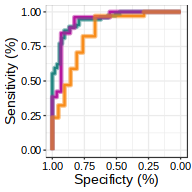

In [17]:

options(repr.plot.height=1.6, repr.plot.width=1.6)
ggroc(list("Train"= roc_train, "Test" = roc_test, "Validation"=roc_val), aes=c("color"))  +
    theme_bw(base_size=6) + guides(color="none", linetype="none")+
    geom_line(size=1,alpha=0.5)+ scale_color_manual(values=c("#218380","#B5179E","#F88C1A")) +
xlab("Specificty (%)") + ylab("Sensitivity (%)") +
theme(axis.text=element_text(size=6, color="black"), axis.title=element_text(size=8, color="black"))


In [18]:
ci.auc(roc_train)
ci.auc(roc_test)
ci.auc(roc_val)

95% CI: 0.9052-0.9795 (DeLong)

95% CI: 0.8674-1 (DeLong)

95% CI: 0.7305-0.9585 (DeLong)

## FIG 2C

In [19]:
df_val = df_val[,1:7]
df_val$cohort= "Validation"

In [20]:
youden = coords(roc_train, x="best", input="threshold", best.method="youden")$threshold

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


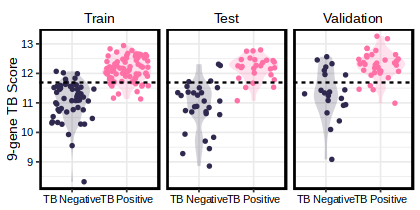

In [21]:
violplot_df = rbind(cbind(df_train[,c(1,2,4)], "cohort"="Train", df_train[,c(10,42,50)]),
cbind(df_test[,c(1,2,4)], "cohort"="Test", df_test[,c(10,42,50)]))
violplot_df$Microbiologic.reference.standard = gsub(violplot_df$Microbiologic.reference.standard, pattern="TB ", replacement="")
colnames(violplot_df)=colnames(df_val)

options(repr.plot.width=3.5, repr.plot.height=1.75)

rbind(violplot_df, df_val) %>% filter(Microbiologic.reference.standard!="") %>% 
mutate(cohort=factor(cohort,levels=c("Train","Test","Validation"))) %>% 
ggplot( aes(x=Microbiologic.reference.standard, y=score)) + 
geom_violin(color=NA, alpha=0.2,aes(fill=Microbiologic.reference.standard)) + theme_bw(base_size=8) +
geom_jitter(aes(color=Microbiologic.reference.standard), size=0.5) + geom_hline(yintercept = youden, linetype="dashed") +
scale_fill_manual(values=c("#2E294E", "#FF70A6"))+ scale_color_manual(values=c("#2E294E", "#FF70A6")) +
theme(legend.position="none", axis.title.x=element_blank(), axis.text=element_text(size=6, color="black"),
     strip.background = element_rect(color="#FFFFFF", fill="#FFFFFF", size=0),
                                 strip.text.x = element_text(size = 8, color = "black"  ),
                                 panel.border = element_rect(colour = "black", fill=NA, size=1)) +
ylab("9-gene TB Score") + facet_wrap(.~cohort) +
scale_x_discrete(labels=c("TB Negative","TB Positive"))

## FIG 2D

In [22]:
counts_val = read.delim("../files_for_manuscript/count_matrix_validation.txt", row.names=c(1))
metadata_val = read.delim("../files_for_manuscript/metadata_validation.txt", header=T)
counts = read.delim("../files_for_manuscript/count_matrix.txt", row.names=c(1))

In [23]:
metadata_val$`Semiquant.Xpert.result.3`[metadata_val$Semiquant.Xpert.result.3 == "Trace"]= "Low"
metadata_val$`Semiquant.Xpert.result.3`[metadata_val$Semiquant.Xpert.result.3 == "Very low"]= "Low"
metadata_val$`Semiquant.Xpert.result.3`[metadata_val$Microbiologic.reference.standard == "Negative"]= "Negative"

In [24]:
counts_all = merge(counts, counts_val, by="row.names", all=T)
counts_all[is.na(counts_all)]=0
rownames(counts_all)=counts_all$Row.names
counts_all = counts_all[,-1]

In [25]:
gene_counts = counts_all[rownames(counts_all) %in% gene.list[gene.list$gene_name %in% top$x,1],] %>% 
edgeR::cpm() %>% data.frame() %>%
filter(rownames(.)%in% best_genes) %>% data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1))  

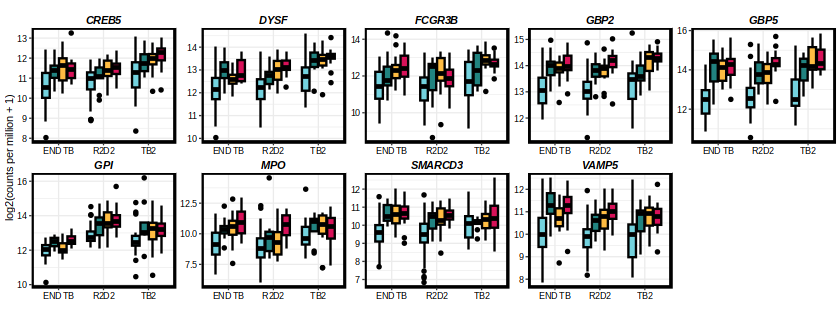

In [26]:
gene_counts_plot =gene_counts %>% mutate(gene_id = rownames( .)) %>%
    merge(gene.list[,1:2], ., by="gene_id")  %>%
    melt(. , id.vars=c("gene_id","gene_name")) %>% merge(metadata_val, ., by.x="Cornell_ID", by.y="variable") %>% 
mutate(Semiquant.Xpert.result.3 = factor(Semiquant.Xpert.result.3, levels=c("Negative","Low","Medium","High"))) 
options( repr.plot.width=7, repr.plot.height=2.6)


gene_counts_plot[gene_counts_plot$value!=0,] %>% filter(!is.na(Semiquant.Xpert.result.3)) %>% 
ggplot( aes(x=cohort, y=value, fill=Semiquant.Xpert.result.3))+ geom_boxplot(outlier.size = 0.5, color="black") + 
    theme_bw(base_size=6) + theme(axis.text.x=element_text(color="black"), axis.title.x=element_blank(),
                                  axis.text=element_text( color="black"), 
                                  axis.title=element_text(color="black"), legend.position="none", 
                                  title=element_text(size=6, color="black"), 
                                 strip.background = element_rect(color="#FFFFFF", fill="#FFFFFF", size=0),
                                 strip.text.x = element_text(size = 6, color = "black", face = "bold.italic"  ),
                                 panel.border = element_rect(colour = "black", fill=NA, size=1),
                                 panel.spacing.y = unit(0.15, "mm"),
                                 aspect.ratio=0.8) +
    scale_fill_manual(values=c("#73D2DE","#218380","#FFBC42","#D81159")) + facet_wrap(.~gene_name, scales="free", ncol=5)+
scale_x_discrete(labels=c("END TB", "R2D2", "TB2")) +
ylab("log2(counts per million + 1)")

## FIG 2E

In [27]:
semiq_counts = counts_all[rownames(counts_all) %in% gene.list[gene.list$gene_name %in% top$x,1],] %>% 
edgeR::cpm() %>% data.frame() %>%
filter(rownames(.)%in% best_genes) %>% data.frame() %>% mutate_all(as.numeric) %>% 
mutate( log2( . +1))  %>% summarise_all(mean) %>%
t() %>% data.frame() %>% set_colnames("score" ) %>% tibble::add_column('sample'=rownames( . )) %>%
merge(. , metadata_val, by.x="sample",by.y="Cornell_ID") %>%
filter(Semiquant.Xpert.result.3 !="") %>% 
mutate(Semiquant.Xpert.result.3 = factor(Semiquant.Xpert.result.3, levels=c("Negative","Low","Medium","High"))) %>%
   group_by(Semiquant.Xpert.result.3, cohort)%>% summarise(mean = mean(score, na.rm = TRUE),
                                                             sd = sd(score, na.rm = TRUE),
                                                             n = n()) %>%
    mutate(se = sd / sqrt(n),
           lower.ci = mean - qt(1 - (0.05 / 2), n - 1) * se,
           upper.ci = mean + qt(1 - (0.05 / 2), n - 1) * se)

semiq_counts$cohort[semiq_counts$cohort=="GHL"]= "END TB"

`summarise()` has grouped output by 'Semiquant.Xpert.result.3'. You can
override using the `.groups` argument.


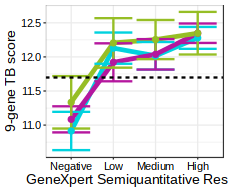

In [43]:
options(repr.plot.height=1.6, repr.plot.width=1.9)
semiq_counts %>% 
    mutate(Semiquant.Xpert.result.3 = factor(Semiquant.Xpert.result.3, levels=c("Negative","Low","Medium","High"))) %>%
filter(Semiquant.Xpert.result.3 !="") %>%
    ggplot(aes(x=Semiquant.Xpert.result.3, y=mean, color=cohort, group=cohort)) + 
    geom_line(size=1) + geom_errorbar( aes(ymin=lower.ci, ymax=upper.ci)) + 
 geom_point(size=1) + theme_bw(base_size=6) +
    theme(legend.position="none",
         axis.text=element_text(color="black", size=6),
         axis.title=element_text(color="black",size=8)) +
    xlab("GeneXpert Semiquantitative Result") + ylab("9-gene TB score")  +
    scale_color_manual(values=c("#00D2DE", "#B5179E","#96be25"))  +
geom_hline(yintercept=youden, linetype="dashed")

## FIG 2F

In [29]:
 cxr = read.delim("../files_for_manuscript/validation_cxr.txt")%>% 
    data.frame() %>%
    dplyr::select("Study.ID", "CAD4TB.score", "Lunit.score", "qXR.score") %>%
    mutate(Study.ID = gsub(Study.ID, pattern="R2D204", replacement='TBSQUARE_cfRNA_')) %>%
    mutate(Study.ID = gsub(Study.ID, pattern="$", replacement="_combined")) %>%
    set_colnames(c("Cornell_ID","CAD4TB.score","Lunit.score","qXR.score")) %>%
    rbind(. ,metadata %>% select(Cornell_ID, "CAD4TB.score","Lunit.score","qXR.score")%>% 
mutate(Cornell_ID = gsub(Cornell_ID, pattern="$", replacement="_combined")), by="Cornell_ID") %>% 
merge(., metadata_val[,c(1,3,5)], by="Cornell_ID") %>%
merge(. , rbind(violplot_df, df_val)[,c(1,2)], by.x="Cornell_ID", by.y="sample") %>%
    filter(!is.na(CAD4TB.score))  %>% filter(Microbiologic.reference.standard !="")  %>% 
    reshape2::melt(.,id.vars=c("Cornell_ID","Microbiologic.reference.standard","score", "cohort")) %>%
mutate(value = as.numeric(value)) %>% mutate(variable = gsub(variable, pattern=".score", replacement=" Score"))

`geom_smooth()` using formula = 'y ~ x'


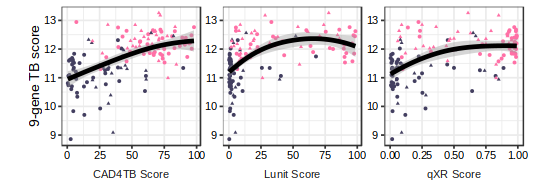

In [30]:
options(repr.plot.height=1.6, repr.plot.width=4.6)

cxr %>% ggplot(aes(x=value, y=score, color=Microbiologic.reference.standard)) + 
geom_point(size=0.5, aes(shape=cohort))+
    theme_bw(base_size=8) + geom_smooth(method="loess", span=2, color="black")+
    theme(legend.position="none", axis.text=element_text(size=6, color="black"), axis.title=element_blank(),
) +ylab("9-gene TB score")+ scale_color_manual(values=c("#433F60", "#FF70A6")) + 
facet_wrap(.~variable, scales="free", strip.position="bottom")+
  theme(
    aspect.ratio = 1,
    strip.background = element_blank(),
    strip.placement = "outside",
      axis.text=element_text(size=6, color="black"),
      axis.title=element_text(size=8, color="black"),
      axis.title.x=element_blank()
  )

In [31]:
cxr %>% group_by(variable) %>% summarise(cor = cor(value, score, method="pearson"))

variable,cor
<chr>,<dbl>
CAD4TB Score,0.5481879
Lunit Score,0.4836928
qXR Score,0.4591850


In [46]:
library(rmarkdown)
convert_ipynb("Fig2_code.ipynb", output = xfun::with_ext("Fig2_code", "Rmd"))